# Wind Power Forecast Model

In [6]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, WindPowerForecastModelParameter, _inv_logit, _logit

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Forecast Simulations

In [21]:
params = WindPowerForecastModelParameter(n_call_strikes=40, min_strike=-7.0, max_strike=7.0)
model = WindPowerForecastModel('Onshore', speed_of_mean_reversion=0.5, volatility=1.5, params=params)

In [22]:
timegrid = np.linspace(0.0,1.0, 365)
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(10_000, timegrid.shape[0]))
results = model.simulate(timegrid, rnd, expiries=[1.0], initial_forecasts=[0.8], startvalue=0.0)

In [23]:
onshore_wind = results.get('Onshore_FWD0')

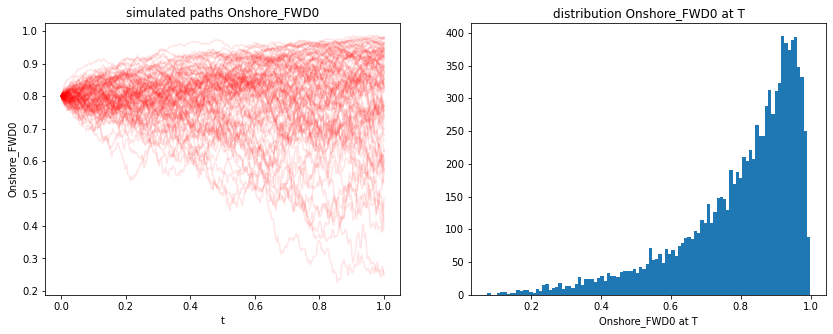

In [31]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for i in range(100):
    plt.plot(timegrid, onshore_wind[:,i],'-r', alpha=0.1)
plt.xlabel('t')
plt.ylabel('Onshore_FWD0')
plt.title('simulated paths Onshore_FWD0')
plt.subplot(1,2,2)
plt.hist(onshore_wind[-1,:], bins=100)
plt.xlabel('Onshore_FWD0 at T')
plt.title('distribution Onshore_FWD0 at T');

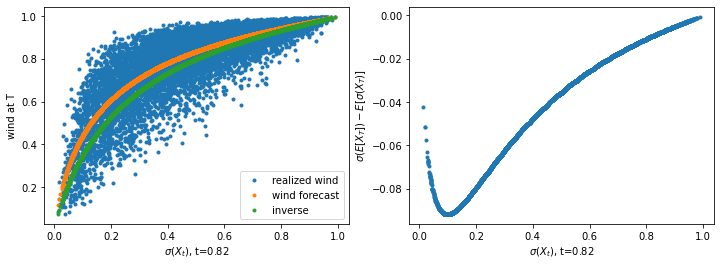

In [45]:
timepoint = 300 # the timepoint used for plotting
t = "{:1.2f}".format(timegrid[timepoint]) # current time as string for axis labels
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x = _inv_logit(results._paths[timepoint,:])
plt.plot(x,onshore_wind[-1,:],
         '.', label='realized wind')
plt.plot(x, onshore_wind[timepoint,:],'.', label='wind forecast')
expected_ou = model.ou.compute_expected_value(results._paths[timepoint,:], 
                                                       T=timegrid[-1]-timegrid[timepoint])
simple_correction = _logit(results.initial_forecasts[0]) - model.ou.compute_expected_value(0.0, T=timegrid[-1])
inv_logit_from_expectation =  _inv_logit(expected_ou+simple_correction) 

plt.plot(x,inv_logit_from_expectation,'.', label='inverse')
plt.xlabel('$\sigma(X_t)$, t='+t)
plt.ylabel('wind at T')
plt.legend();
plt.subplot(1,2,2)
plt.plot(x, inv_logit_from_expectation-onshore_wind[timepoint,:],'.')
plt.xlabel('$\sigma(X_t)$, t='+t)
plt.ylabel('$\sigma(E[X_T])-E[\sigma(X_T)]$');